In [14]:
############################

############################
### import modules

import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
from scipy import interpolate
import os

###########################

np.set_printoptions(suppress=True)

In [ ]:
############################
### user inputs 

SSMfluxB8 = 5.46e6 #/ cm^2 s  SSM variant: B16-GS98, uncer = 12%
# add SNO B8 flux measurement

inEres = 0.05 # assumed percentage energy resolution at 1 MeV


#############################

numflux = SSMfluxB8  

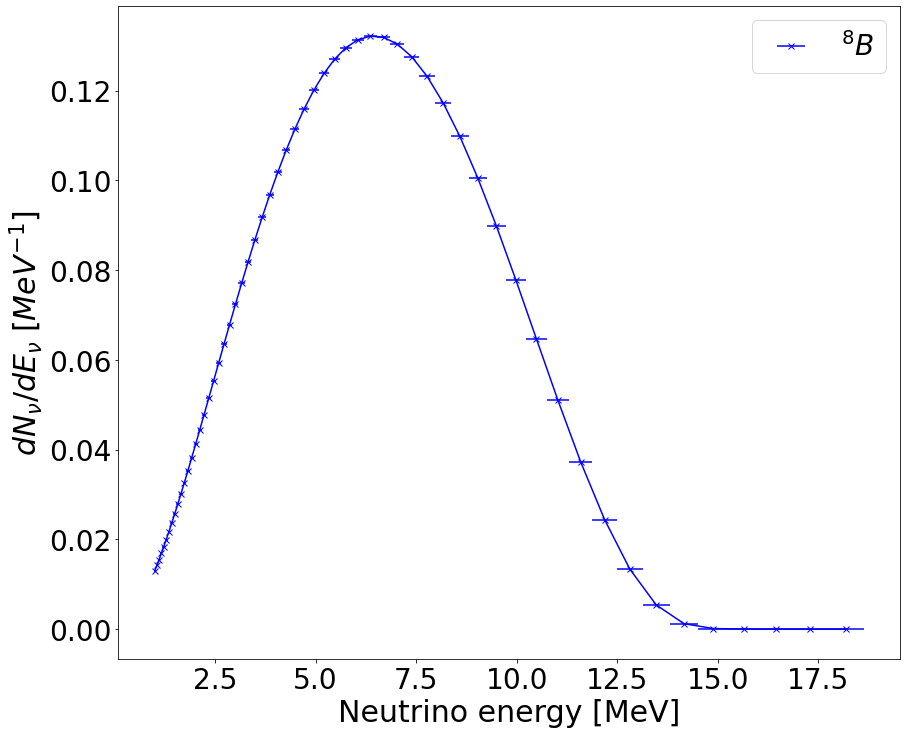

Energy: array([ 1.        ,  1.05128205,  1.10519395,  1.16187056,  1.22145367,
        1.28409232,  1.34994321,  1.41917106,  1.49194907,  1.56845928,
        1.64889309,  1.73345171,  1.82234666,  1.91580034,  2.01404651,
        2.11733095,  2.22591202,  2.34006136,  2.4600645 ,  2.58622166,
        2.71884841,  2.85827653,  3.00485482,  3.15894993,  3.32094737,
        3.49125236,  3.67029094,  3.85851099,  4.05638335,  4.26440301,
        4.48309034,  4.71299241,  4.95468433,  5.20877071,  5.47588715,
        5.75670188,  6.05191736,  6.3622721 ,  6.68854246,  7.03154464,
        7.39213667,  7.7712206 ,  8.16974473,  8.588706  ,  9.02915246,
        9.49218592,  9.97896469, 10.49070647, 11.02869142, 11.59426533,
       12.18884304, 12.81391192, 13.47103561, 14.16185794, 14.88810707,
       15.65159974, 16.45424588, 17.29805336, 18.18513302])
Flux spectrum: array([0.0130196 , 0.01419637, 0.0154725 , 0.01685603, 0.01835099,
       0.01996942, 0.02171327, 0.02359004, 0.02561341, 0.0

In [44]:
os.chdir("../data")  # moves working directory to data folder

### imports energy spectrum shape

EvB8 = np.array([])
EvdataB8 = np.array([])
with open('bahcallB8spectrum.csv', 'r') as file: # should add commas to this file
    reader = csv.reader(file)
    for row in reader:
        temp = row[0].split()
        EvB8 = np.append(EvB8, float(temp[0])) # energy values
        EvdataB8 = np.append(EvdataB8, float(temp[1])) # normalisation units
        
### plot energy spectrum 

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

poptB8, pcovB8 = curve_fit(gaus, EvB8, EvdataB8)

###############################

### variable bin widths based on energy resolution

x = 1 # corresponds to 1 MeV
sigmawidth = 0.5 # corresponds to a bin width of 1 sigma, controls bin purity

points = np.array([x])
uncer = np.array([inEres*sigmawidth*x])
edges = np.array([x - inEres*sigmawidth*x, x + inEres*sigmawidth*x])

while x < 18:
    xtemp = x*((1+sigmawidth*inEres)/(1-sigmawidth*inEres))  # add 1/E energy dependence
    uncertemp = inEres*sigmawidth*xtemp
    
    uncer = np.append(uncer, uncertemp)
    points = np.append(points, xtemp)
    edges = np.append(edges, xtemp+ inEres*sigmawidth*xtemp)
    
    x = xtemp

x = points
bwidth = 2*uncer

###############################

tckB8 = interpolate.splrep(EvB8, EvdataB8)
yB8 = interpolate.splev(x, tckB8, der=0)

yB8[yB8 < 0] = 0 # removes negative values
fluxspec = yB8 

plt.figure(figsize=(14,12))

plt.plot(x, yB8, color="blue")
plt.errorbar(x, yB8, xerr=uncer, linestyle='', marker="x", color="blue", label=r'${}^{8}B$')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel(r'$d N_{\nu}/d E_{\nu}$ [$MeV^{-1}$]',fontsize=30)
plt.xticks(fontsize=28)

plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

print('Energy:', repr(x[0:len(fluxspec)]))
print('Flux spectrum:', repr(fluxspec))
print('Peak energy:', x[fluxspec == np.max(fluxspec)])
print('Normalisation:', np.sum(yB8*bwidth))

[ 0.00089147  0.0008425   0.00077922  0.00069939  0.00060046  0.00047956
  0.00033344  0.00015843 -0.00004957 -0.00029519 -0.00058356 -0.00092039
 -0.00131198 -0.00176526 -0.00228776 -0.00288766 -0.0035737  -0.00435514
 -0.00524171 -0.00624345 -0.00737061 -0.0086334  -0.01004187 -0.01160563
 -0.01333365 -0.01523406 -0.01731393 -0.01957917 -0.02203442 -0.02468306
 -0.02752727 -0.03056815 -0.03380593 -0.03724025 -0.0408704  -0.0446956
 -0.04871534 -0.0529296  -0.05733907 -0.06194534 -0.06675106 -0.07175996
 -0.07697699 -0.08240826 -0.08806104 -0.09394376 -0.1000659  -0.10643794
 -0.1130713  -0.11997824 -0.12717179 -0.13466565 -0.14247407 -0.15061183
 -0.15909406 -0.16793617 -0.17715375 -0.18676236 -0.19677748]
[ 0.00096779  0.00097715  0.0009821   0.00098181  0.00097532  0.00096151
  0.00093913  0.00090674  0.00086268  0.00080509  0.00073182  0.00064047
  0.00052828  0.00039215  0.00022858  0.00003362 -0.00019713 -0.00046861
 -0.00078632 -0.00115632 -0.00158531 -0.00208059 -0.00265008 -0

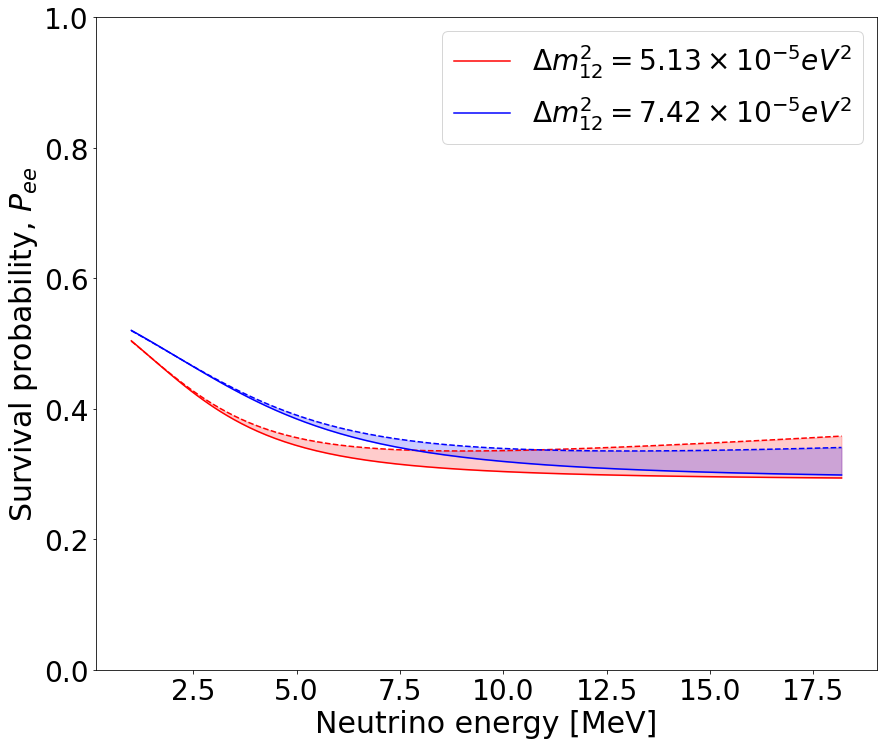

In [16]:
def osc(E, md12):
    
    E = E*1e6
    
    degrad = math.pi/180 # deg.s to rad.s conversion fac.
    
    #E = 6e6 # 6e6 eV, B8 peak
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 

    Gf =  8.958e-44  #eV m3, Fermi constant
    Amsw = 1 # divergence from msw theory
    
    ######################################
    # oscillation parameters:

    #md12 = 7.42e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = 33.4*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*Amsw*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*Amsw*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2)
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    pn = pd - c2a12S*(c13**2)*freg
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)
    
    print(asym)

    return pd, pn

plt.figure(figsize=(14,12))

pd1, pn1 = osc(x, 5.13e-5)
pd2, pn2 = osc(x, 7.42e-5)


plt.plot(x, pd1, marker="o", markersize=0, color="red", label=r'$\Delta m_{12}^2 = 5.13 \times 10^{-5} eV^2$')
plt.plot(x, pn1, marker="x", markersize=0, color="red", linestyle='dashed')
plt.fill_between(x, pd1, pn1, color='red', alpha=0.2)

plt.plot(x, pd2, marker="x", markersize=0, color="blue", label=r'$\Delta m_{12}^2 = 7.42 \times 10^{-5} eV^2$')
plt.plot(x, pn2, marker="x", markersize=0, color="blue", linestyle='dashed')
plt.fill_between(x, pd2, pn2, color='blue', alpha=0.2)

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'Survival probability, $P_{ee}$',fontsize=30)
plt.yticks(fontsize=28)
plt.ylim(0,1)
#plt.title("SNOwGLoBES", fontsize=20)

plt.legend(fontsize=28)

plt.show()

#################


In [17]:
npath = '/home/lane/notebook/solar/'
cpath = '/Users/Clara Escanuela/Downloads/'

genpath = npath # general path

def optim_bins(mult_arry):
    
    #import astropy
    #from astropy import stats
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    print(energy_res)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['mst']
    Ex = np.array(rTree_event['Ex'])
    Ev = np.array(rTree_event['Ev'])
    KEl = np.array(rTree_event['KEl'])
    pdgp = np.array(rTree_event['pdgp'])
    Ep = np.array(rTree_event['Ep'])
    xsec = np.array(rTree_event['xsec'])
    
    return Ex, Ev, KEl, pdgp, Ep, xsec

filename = 'B8_marsum.root'

Ex, Ev, KEl, pdgp, Ep, xsec = root_input(genpath, filename)

In [18]:
n, binedges = np.histogram(Ev, edges, density=True) # bin edges taken

print(n)
print(binedges)

print(totflux)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00032655 0.00084805 0.00171185
 0.00299347 0.00513899 0.00754438 0.0107127  0.01454376 0.01990028
 0.02807705 0.03853026 0.05189172 0.06634673 0.08570188 0.10522414
 0.1268681  0.14960577 0.16999381 0.18647127 0.19724692 0.19712876
 0.1869161  0.16425707 0.12770039 0.08310499 0.04033988 0.0115112
 0.001698   0.00008945 0.         0.         0.        ]
[ 0.975       1.025       1.0775641   1.1328238   1.19091733  1.25199001
  1.31619463  1.38369179  1.45465034  1.52924779  1.60767076  1.69011541
  1.776788    1.86790533  1.96369535  2.06439767  2.17026422  2.28155982
  2.39856289  2.52156612  2.6508772   2.78681962  2.92973345  3.07997619
  3.23792368  3.40397105  3.57853367  3.76204822  3.95497377  4.15779293
  4.3710

59 59
2.8405979671616493


/tmp/ipykernel_22367/3058651637.py:6: RuntimeWarning: invalid value encountered in true_divide
  crosssec = (n*numflux*np.mean(xsec))/totflux


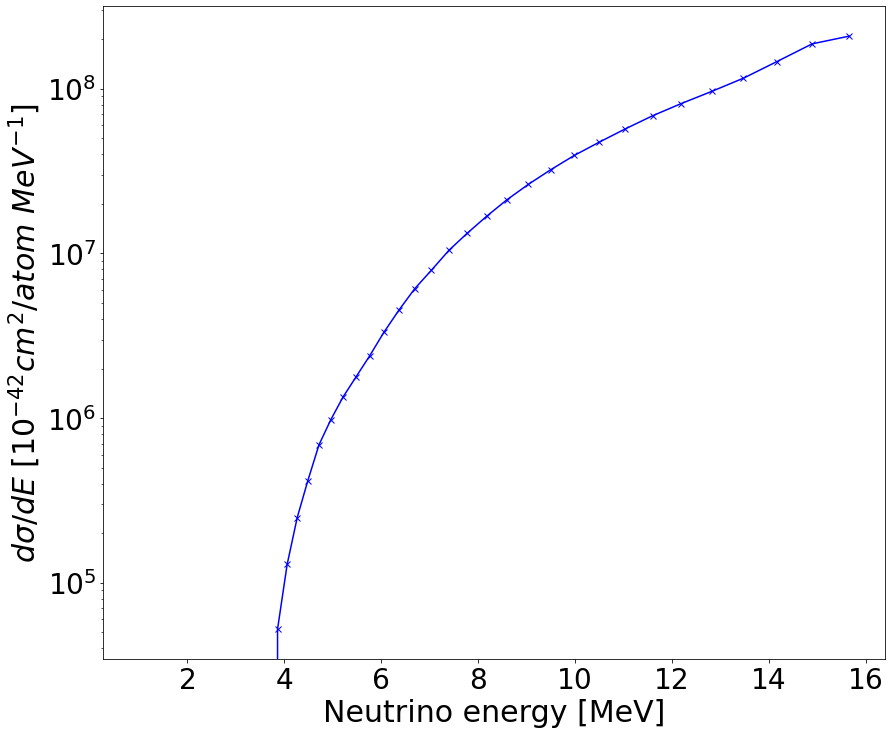

In [19]:
plt.figure(figsize=(14,12))

print(len(n), len(totflux))
print(np.mean(xsec))

crosssec = (n*numflux*np.mean(xsec))/totflux

plt.plot(x, crosssec, marker="x", color="blue")
plt.yscale('log')
plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('$d\sigma/dE$ [$10^{-42} cm^{2}/atom\ MeV^{-1}$]',fontsize=30)
plt.yticks(fontsize=28)
#plt.ylim(0,1)
#plt.title("SNOwGLoBES", fontsize=20)

plt.show()

[ 1.          1.05128205  1.10519395  1.16187056  1.22145367  1.28409232
  1.34994321  1.41917106  1.49194907  1.56845928  1.64889309  1.73345171
  1.82234666  1.91580034  2.01404651  2.11733095  2.22591202  2.34006136
  2.4600645   2.58622166  2.71884841  2.85827653  3.00485482  3.15894993
  3.32094737  3.49125236  3.67029094  3.85851099  4.05638335  4.26440301
  4.48309034  4.71299241  4.95468433  5.20877071  5.47588715  5.75670188
  6.05191736  6.3622721   6.68854246  7.03154464  7.39213667  7.7712206
  8.16974473  8.588706    9.02915246  9.49218592  9.97896469 10.49070647
 11.02869142 11.59426533 12.18884304 12.81391192 13.47103561 14.16185794
 14.88810707 15.65159974 16.45424588 17.29805336 18.18513302]


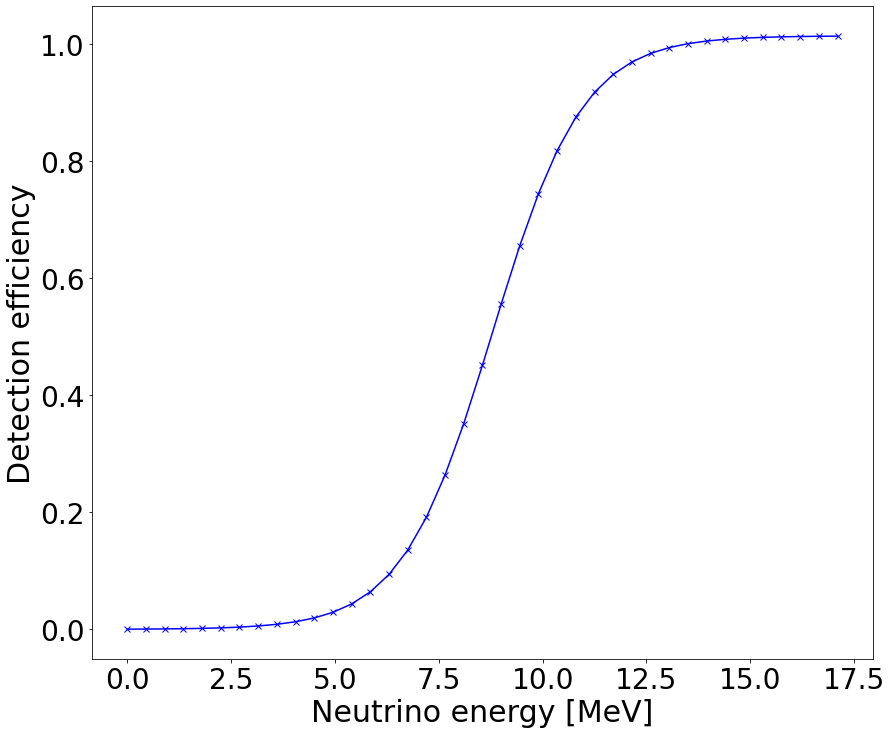

[ 1.          1.05128205  1.10519395  1.16187056  1.22145367  1.28409232
  1.34994321  1.41917106  1.49194907  1.56845928  1.64889309  1.73345171
  1.82234666  1.91580034  2.01404651  2.11733095  2.22591202  2.34006136
  2.4600645   2.58622166  2.71884841  2.85827653  3.00485482  3.15894993
  3.32094737  3.49125236  3.67029094  3.85851099  4.05638335  4.26440301
  4.48309034  4.71299241  4.95468433  5.20877071  5.47588715  5.75670188
  6.05191736  6.3622721   6.68854246  7.03154464  7.39213667  7.7712206
  8.16974473  8.588706    9.02915246  9.49218592  9.97896469 10.49070647
 11.02869142 11.59426533 12.18884304 12.81391192 13.47103561 14.16185794
 14.88810707 15.65159974 16.45424588 17.29805336 18.18513302]


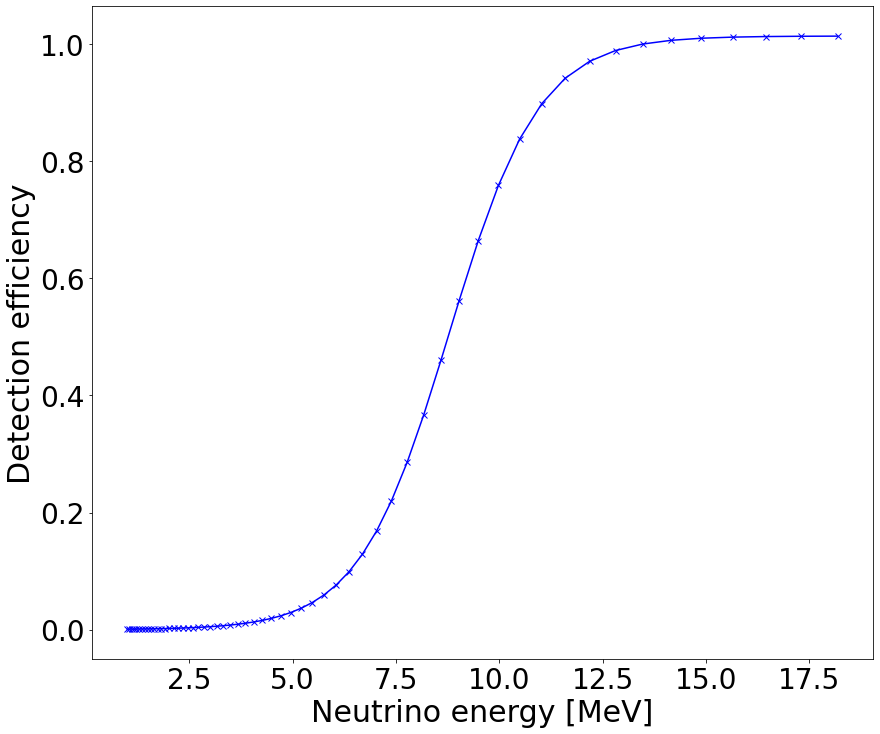

In [20]:
#Efficiency

def sigmoid(x, a, b, c):
    return a/(1 + np.exp(-b*x+c))


energy = np.array([ 0.  ,  0.45,  0.9 ,  1.35,  1.8 ,  2.25,  2.7 ,  3.15,  3.6 ,
        4.05,  4.5 ,  4.95,  5.4 ,  5.85,  6.3 ,  6.75,  7.2 ,  7.65,
        8.1 ,  8.55,  9.  ,  9.45,  9.9 , 10.35, 10.8 , 11.25, 11.7 ,
       12.15, 12.6 , 13.05, 13.5 , 13.95, 14.4 , 14.85, 15.3 , 15.75,
       16.2 , 16.65, 17.1])

params = [1.01391104, 0.91687735, 8.06047126]

plt.figure(figsize=(14,12))

plt.errorbar(energy, sigmoid(energy, *params), color='blue', marker='x', label='0.1')

plt.ylabel('Detection efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

print(x)

plt.show()


############################

plt.figure(figsize=(14,12))

plt.plot(x, sigmoid(x, *params), color='blue', marker='x', label='0.1')

plt.ylabel('Detection efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

print(x)

plt.show()

/tmp/ipykernel_22367/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
/tmp/ipykernel_22367/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
/tmp/ipykernel_22367/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)


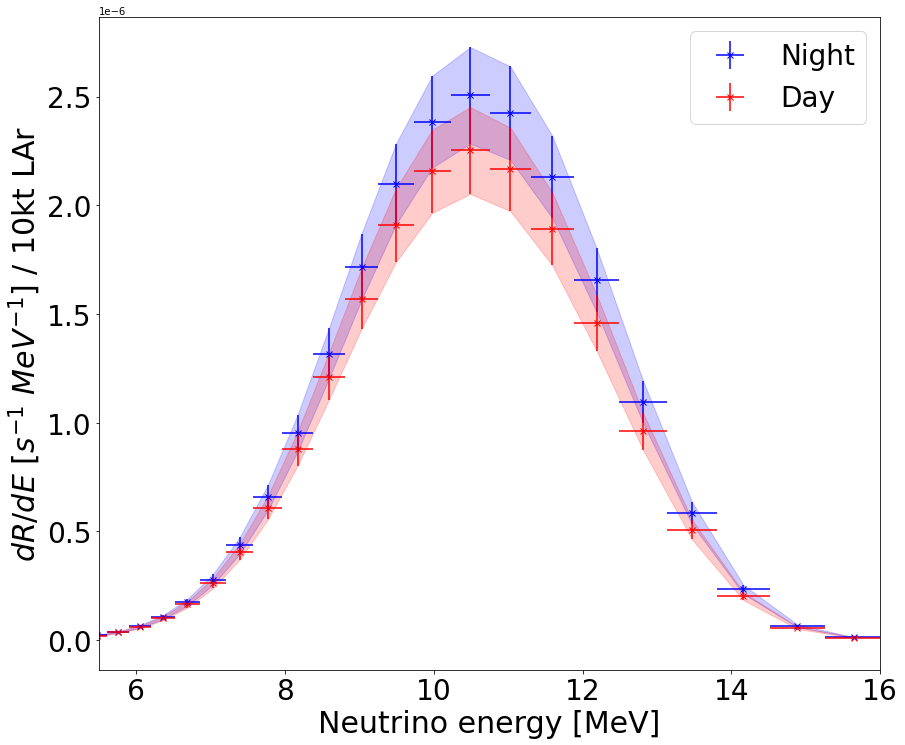

9.696793193989904e-06 1.0783883585006748e-05


In [21]:
plt.figure(figsize=(14,12))

#Gaussian function

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def f(x, A, B):
    return A*x + B

def R_errors(R, eff_std, flux_std, cross_perc):
    
    cross_std = (cross_perc/100)*crosssec
    cross_std[np.isnan(cross_std)] = 0
    cross_std[np.isinf(cross_std)] = 0
    
    R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
    return np.sqrt(R_var)

resol = inEres
a = np.sqrt(2*np.pi)*resol

sigma = resol
params_lin = [0.99960798, -1.50237267]
eff = sigmoid(x, *params)

nt = 10e31 # number of target atoms in 10kT LAr module
fac = 1e-42 # cross-section factor

intnight_E = np.array([])
intday_E = np.array([])

#totflux = 5.25*10**6  #cm-2s-1, SNO

flux_std = 0.2/5.25
cross_perc = 8 #%
eff_std=0

for i in range(0, len(x)):
    
    convener = f(x, params_lin[0], params_lin[1])
    convE = f(x[i], params_lin[0], params_lin[1])
    
    nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    nightval[np.isnan(nightval)] = 0
    intnight_E = np.append(intnight_E, sum(nightval))
    
for i in range(0, len(x)):
    
    convener = f(x, params_lin[0], params_lin[1])
    convE = f(x[i], params_lin[0], params_lin[1])
    
    dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
    dayval[np.isnan(dayval)] = 0
    intday_E = np.append(intday_E, sum(dayval))

plt.errorbar(x, intnight_E, xerr=uncer, linestyle='',yerr=R_errors(intnight_E, eff_std, flux_std, cross_perc), marker="x", color="blue", label='Night')
plt.errorbar(x, intday_E, xerr=uncer, linestyle='',yerr=R_errors(intday_E, eff_std, flux_std, cross_perc), marker="x", color="red", label='Day')

plt.fill_between(x, (intnight_E)+R_errors(intnight_E, eff_std, flux_std, cross_perc), (intnight_E)-R_errors(intnight_E, eff_std, flux_std, cross_perc), color='blue', alpha=0.2)
plt.fill_between(x, (intday_E)+R_errors(intday_E, eff_std, flux_std, cross_perc), (intday_E)-R_errors(intday_E, eff_std, flux_std, cross_perc), color='red', alpha=0.2)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)

plt.ylabel('$dR/dE$ [$s^{-1}\ MeV^{-1}$] / $10$kt LAr',fontsize=30)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)

plt.xlim(5.5,16)

#plt.ylim(0, 1500)
#plt.title("SNOwGLoBES", fontsize=20)
plt.show()

rateday = np.sum(intday_E*bwidth)
ratenight = np.sum(intnight_E*bwidth)
print(rateday, ratenight)

In [22]:
def asymerr(night, day, back):
    #print(night, day)
    
    tempasymmetry = 2*(night-day)/(night+day+2*back)
    #tempuncer = np.sqrt(((2*((2*day + 2*back)/(night + day + 2*back)))**2)*((1/np.sqrt(night))**2) + 
    #                ((2*((2*night + 2*back)/(day + night + 2*back)))**2)*((1/np.sqrt(day))**2) +
    #                ((2*((2*(night - day))/(night + day + 2*back)**2))**2)*((1/np.sqrt(back))**2)) 
    
    tempuncer = np.sqrt((4*(day+back)/(night+day+back)**2)**2*(day) + (4*(night+back)/(night+day+back)**2)**2*(night) 
                        +(4*(night-day)/(night+day+back)**2)**2*(back))
    
    sumasym = np.sum((tempasymmetry/tempuncer**2)[~np.isnan(tempasymmetry/tempuncer**2)])
    sumuncer = np.sum((1/tempuncer**2)[~np.isinf(1/tempuncer**2)])
    
    asymoutput = (sumasym/sumuncer)
    uncerstat = np.sqrt(1/sumuncer)
    
    uncersys = 0.1
    
    unceroutput = np.sqrt((uncerstat/asymoutput)**2 + uncersys**2)
    
    return asymoutput*100, asymoutput*unceroutput*100, tempasymmetry, tempuncer

back = 1e0

#expo_time = np.linspace(1, 20, 19)

years = 5
expo = years*3.14e7*4

#asym_array = np.array([])
#uncer_array = np.array([])

#for i in range(0, len(expo_time)):
#    asym_a, uncer_a, asymarray_a, uncerarray_a = asymerr(ratenight*expo_time[i]*3.14e7, rateday*expo_time[i]*3.14e7, back)
#    asym_array = np.append(asym_array, asym_a)
#    uncer_array = np.append(uncer_array, uncer_a)

asymfin, uncerfin, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)

print("Night-day asymmetry:", asymfin, "+/-", uncerfin, "%")
#print(rateday*expo)

#print(osc(10, 5.13e-5))
#print(asym_array)

Night-day asymmetry: 10.614115814263265 +/- 2.0646661702992257 %


In [23]:
def osc(md12):
    
    degrad = math.pi/180 # deg.s to rad.s conversion fac.
    
    E = 10.5e6 # 6e6 eV, B8 peak
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 

    Gf =  8.958e-44  #eV m3, Fermi constant
    Amsw = 1 # divergence from msw theory
    
    ######################################
    # oscillation parameters:

    #md12 = 7.42e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = 33.4*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*Amsw*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*Amsw*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2)
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)
    
    return asym

def asym(years, vol):
    
    resol = inEres
    a = np.sqrt(2*np.pi)*resol

    sigma = resol
    params_lin = [0.99960798, -1.50237267]
    eff = sigmoid(x, *params)

    nt = vol*10e31 # number of target atoms in 10kT LAr module
    fac = 1e-42 # cross-section factor

    intnight_E = np.array([])
    intday_E = np.array([])

    #totflux = 5.25*10**6  #cm-2s-1, SNO

    flux_std = 0.2/5.25
    cross_perc = 8 #%
    eff_std=0

    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
        nightval[np.isnan(nightval)] = 0
        intnight_E = np.append(intnight_E, sum(nightval))
    
    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
        dayval[np.isnan(dayval)] = 0
        intday_E = np.append(intday_E, sum(dayval))

    upbndn = np.sum((intnight_E + R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E + R_errors(intnight_E, eff_std, flux_std, cross_perc)))]) 
    lowbndn = np.sum((intnight_E - R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E - R_errors(intnight_E, eff_std, flux_std, cross_perc)))])
    
    upbndd = np.sum((intday_E + R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E + R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    lowbndd = np.sum((intday_E - R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E - R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    
    rateday = np.sum(intday_E*bwidth)
    ratenight = np.sum(intnight_E*bwidth)
    
    
    expo = years*3.14e7

    asym, uncer, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)
    asymup, uncerup, asymarrayup, uncerarrayup = asymerr(upbndn*expo, upbndd*expo, back)
    asymlow, uncerlow, asymarraylow, uncerarraylow = asymerr(lowbndn*expo, lowbndd*expo, back)
    
    asymexp = -osc(7.42e-5)*100
    
    return ((asym-asymexp)**2/uncer**2)**0.5, ((asymup-asymexp)**2/uncerup**2)**0.5, ((asymlow-asymexp)**2/uncerlow**2)**0.5, asym, uncer

yarray = np.arange(0.01, 30, 0.01)
sarray = np.array([])
sarrayup = np.array([])
sarraylow = np.array([])

for elem in yarray:
    temp = asym(elem, 1)
    
    sarray = np.append(sarray, temp[0])
    sarrayup = np.append(sarrayup, temp[1])
    sarraylow = np.append(sarraylow, temp[2])
    
sarray40 = np.array([])
sarrayup40 = np.array([])
sarraylow40 = np.array([])

for elem in yarray:
    temp = asym(elem, 4)
    
    sarray40 = np.append(sarray40, temp[0])
    sarrayup40 = np.append(sarrayup40, temp[1])
    sarraylow40 = np.append(sarraylow40, temp[2])
    
sarray70 = np.array([])
sarrayup70 = np.array([])
sarraylow70 = np.array([])

for elem in yarray:
    temp = asym(elem, 7)
    
    sarray70 = np.append(sarray70, temp[0])
    sarrayup70 = np.append(sarrayup70, temp[1])
    sarraylow70 = np.append(sarraylow70, temp[2])
    

/tmp/ipykernel_22367/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)


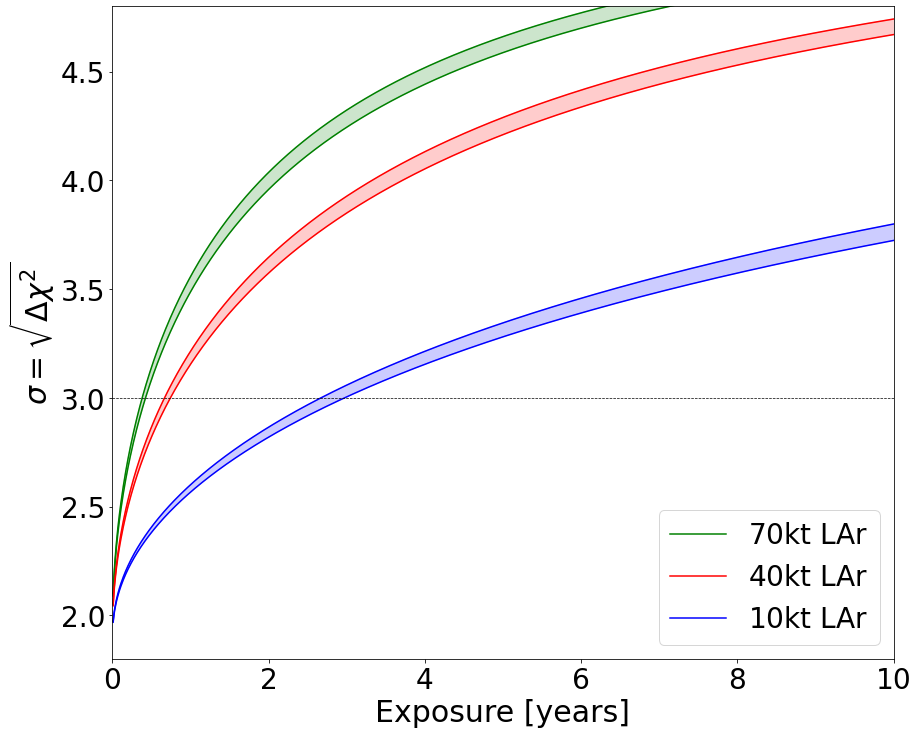

In [24]:
def chisquar(obs, uncer, exp):
    
    chisquar = ((obs - exp)**2)/uncer**2
    
    return chisquar

#KL = [7.54e-5, 0.18e-5] # measurement and error
#asymDUNE = [osc(5.13e-5), osc(5.13e-5)*0.15]
globsolar = [5.13e-5, 1.25e-5]

#chiKL = chisquar(KL[0], KL[1], x)
#chiDUNE = chisquar(asymDUNE[0], asymDUNE[1], osc(x))
chiGS = chisquar(globsolar[0], globsolar[1], 7.54e-5) # global solar

y = chiGS**0.5


plt.figure(figsize=(14,12))

plt.plot(yarray, sarrayup70+y, color='green', marker='x', markersize=0, label='$70$kt LAr')
plt.plot(yarray, sarraylow70+y, color='green', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow70+y, sarrayup70+y, color='green', alpha=0.2)

#########################

plt.plot(yarray, sarrayup40+y, color='red', marker='x', markersize=0, label='$40$kt LAr')
plt.plot(yarray, sarraylow40+y, color='red', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow40+y, sarrayup40+y, color='red', alpha=0.2)

########################

#plt.plot(yarray, sarray, color='blue', marker='x')
plt.plot(yarray, sarrayup+y, color='blue', marker='x', markersize=0, label='$10$kt LAr')
plt.plot(yarray, sarraylow+y, color='blue', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow+y, sarrayup+y, color='blue', alpha=0.2)

plt.ylabel(r'$\sigma = \sqrt{\Delta \chi^2}$', fontsize=30)
plt.xlabel(r'Exposure [years]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.axhline(y=3, color='black', linestyle='--', linewidth=0.7)
plt.axhline(y=5, color='black', linestyle='--', linewidth=0.7)

plt.xlim(0,10)
plt.ylim(1.8,4.8)

#plt.yscale('log')

plt.legend(fontsize=28)
plt.show()



In [25]:
def asym(years, vol):
    
    resol = inEres
    a = np.sqrt(2*np.pi)*resol

    sigma = resol
    params_lin = [0.99960798, -1.50237267]
    eff = sigmoid(x, *params)

    nt = vol*10e31 # number of target atoms in 10kT LAr module
    fac = 1e-42 # cross-section factor

    intnight_E = np.array([])
    intday_E = np.array([])

    #totflux = 5.25*10**6  #cm-2s-1, SNO

    flux_std = 0.2/5.25
    cross_perc = 8 #%
    eff_std=0

    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
        nightval[np.isnan(nightval)] = 0
        intnight_E = np.append(intnight_E, sum(nightval))
    
    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
        dayval[np.isnan(dayval)] = 0
        intday_E = np.append(intday_E, sum(dayval))

    upbndn = np.sum((intnight_E + R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E + R_errors(intnight_E, eff_std, flux_std, cross_perc)))]) 
    lowbndn = np.sum((intnight_E - R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E - R_errors(intnight_E, eff_std, flux_std, cross_perc)))])
    
    upbndd = np.sum((intday_E + R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E + R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    lowbndd = np.sum((intday_E - R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E - R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    
    rateday = np.sum(intday_E*bwidth)
    ratenight = np.sum(intnight_E*bwidth)
    
    
    expo = years*3.14e7

    asym, uncer, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)
    asymup, uncerup, asymarrayup, uncerarrayup = asymerr(upbndn*expo, upbndd*expo, back)
    asymlow, uncerlow, asymarraylow, uncerarraylow = asymerr(lowbndn*expo, lowbndd*expo, back)
    
    asymexp = 0
    
    return ((asym-asymexp)**2/uncer**2)**0.5, ((asymup-asymexp)**2/uncerup**2)**0.5, ((asymlow-asymexp)**2/uncerlow**2)**0.5, asym, uncer

yarray = np.arange(0.01, 30, 0.01)
sarray = np.array([])
sarrayup = np.array([])
sarraylow = np.array([])

for elem in yarray:
    temp = asym(elem, 1)
    
    sarray = np.append(sarray, temp[0])
    sarrayup = np.append(sarrayup, temp[1])
    sarraylow = np.append(sarraylow, temp[2])
    
sarray40 = np.array([])
sarrayup40 = np.array([])
sarraylow40 = np.array([])

for elem in yarray:
    temp = asym(elem, 4)
    
    sarray40 = np.append(sarray40, temp[0])
    sarrayup40 = np.append(sarrayup40, temp[1])
    sarraylow40 = np.append(sarraylow40, temp[2])
    
sarray70 = np.array([])
sarrayup70 = np.array([])
sarraylow70 = np.array([])

for elem in yarray:
    temp = asym(elem, 7)
    
    sarray70 = np.append(sarray70, temp[0])
    sarrayup70 = np.append(sarrayup70, temp[1])
    sarraylow70 = np.append(sarraylow70, temp[2])
    



/tmp/ipykernel_22367/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)


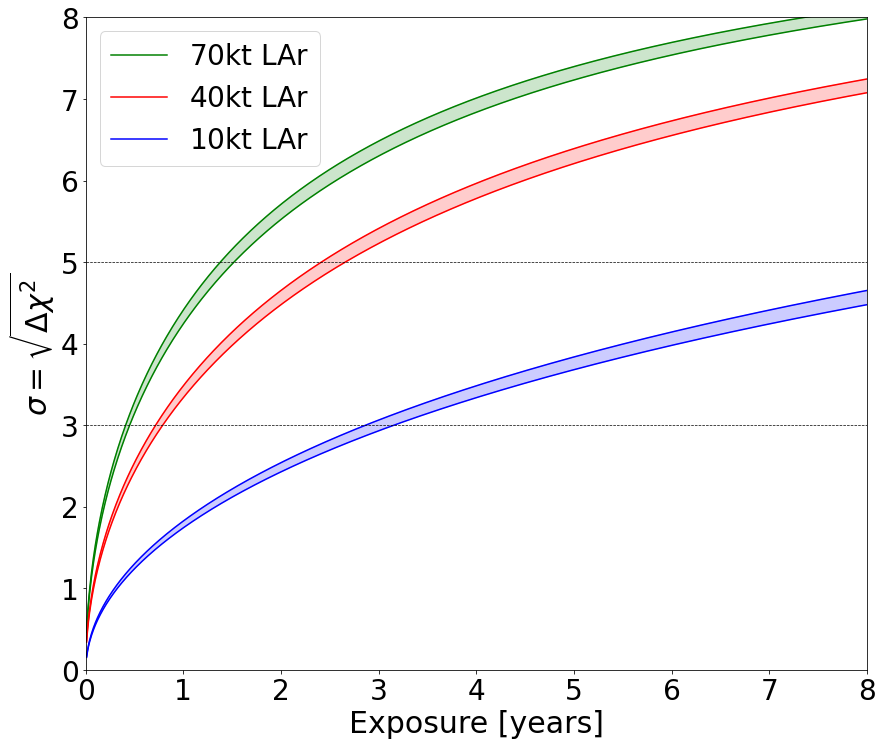

In [26]:

plt.figure(figsize=(14,12))

plt.plot(yarray, sarrayup70, color='green', marker='x', markersize=0, label='$70$kt LAr')
plt.plot(yarray, sarraylow70, color='green', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow70, sarrayup70, color='green', alpha=0.2)

#########################

plt.plot(yarray, sarrayup40, color='red', marker='x', markersize=0, label='$40$kt LAr')
plt.plot(yarray, sarraylow40, color='red', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow40, sarrayup40, color='red', alpha=0.2)

########################

#plt.plot(yarray, sarray, color='blue', marker='x')
plt.plot(yarray, sarrayup, color='blue', marker='x', markersize=0, label='$10$kt LAr')
plt.plot(yarray, sarraylow, color='blue', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow, sarrayup, color='blue', alpha=0.2)

plt.ylabel(r'$\sigma = \sqrt{\Delta \chi^2}$', fontsize=30)
plt.xlabel(r'Exposure [years]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.axhline(y=3, color='black', linestyle='--', linewidth=0.7)
plt.axhline(y=5, color='black', linestyle='--', linewidth=0.7)

plt.xlim(0,8)
plt.ylim(0,8)

#plt.yscale('log')

plt.legend(fontsize=28)
plt.show()

In [27]:
print(10.63*0.13)

1.3819000000000001
